# RecSys Transformer Models Tutorial
This tutorial concerns following questions:
1. How to apply SASRec and BERT4Rec transformer models using RecTools?
2. How do SASRec and BERT4Rec models work under the hood?

Transformer models came to recommendation systems from NLP, where they are proved to have a significant impact. As transformers were applied to sequential data it is common to use them for recommender systems, where interactions are ordered by the date of their occurrence. In this tutorial focus is on SASRec and BERT4Rec - models which are considered as a common starting point for transformer application in RecSys. 

## Why transformers from RecTools?

- RecTools implementations [achieve highest metrics on reproducible public benchmarks](https://github.com/blondered/bert4rec_repro?tab=readme-ov-file#rectools-transformers-benchmark-results) against other well-known implementations.

- Simplest interface in `fit` / `recommend` paradigm.
- Item features are added to item embedding net.
- Multiple loss options.

- Advanced training options like custom validation, logging, checkpoints and early stopping are available. See [Advanced training guide](https://github.com/MobileTeleSystems/RecTools/blob/main/examples/tutorials/transformers_advanced_training_guide.ipynb).
- You can customize models architecture any way you like, keeping all of the above benefits. See [Customization guide](https://github.com/MobileTeleSystems/RecTools/blob/main/examples/tutorials/transformers_customization_guide.ipynb).

## Table of Contents

* Prepare data
* SASRec & BERT4Rec
    * SASRec
    * BERT4Rec
    * Main differences
* RecTools implementation 
* Application of models
    * Basic usage
    * Adding item features. Selecting item net components
    * Selecting losses
    * Customizing model 
    * Cross-validation
    * Item-to-item recommendations
    * Inference tricks (inference for cold users)
* Detailed SASRec and BERT4Rec description
    * Dataset processing
    * Transformer layers
    * Losses
* Links

In [27]:
import numpy as np
import os
import pandas as pd
import torch
import typing as tp
import warnings
import threadpoolctl
import re
import plotly.express as px

from lightning_fabric import seed_everything
from pathlib import Path

from rectools import Columns
from rectools.dataset import Dataset
from rectools.metrics import (
    MAP,
    CoveredUsers,
    AvgRecPopularity,
    Intersection,
    HitRate,
    Serendipity,
)
from rectools.models import PopularModel, EASEModel, SASRecModel, BERT4RecModel
from rectools.model_selection import TimeRangeSplitter, cross_validate
from rectools.models.nn.item_net import CatFeaturesItemNet, IdEmbeddingsItemNet
from rectools.visuals import MetricsApp

warnings.simplefilter("ignore")

# Enable deterministic behaviour with CUDA >= 10.2
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

# Random seed
RANDOM_STATE=60
torch.use_deterministic_algorithms(True)
seed_everything(RANDOM_STATE, workers=True)

Seed set to 60


60

## Prepare data

We are using KION dataset for this tutorial. The data was gathered from the users of MTS KION video streaming platform.

In [ ]:
%%time
!wget -q https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_en.zip -O data_en.zip
!unzip -o data_en.zip
!rm data_en.zip

Archive:  data_en.zip
  inflating: data_en/items_en.csv    
  inflating: __MACOSX/data_en/._items_en.csv  
  inflating: data_en/interactions.csv  
  inflating: __MACOSX/data_en/._interactions.csv  
  inflating: data_en/users_en.csv    
  inflating: __MACOSX/data_en/._users_en.csv  
CPU times: user 74.8 ms, sys: 54.9 ms, total: 130 ms
Wall time: 7.07 s


In [28]:
# Download dataset
DATA_PATH = Path("data_en")
items = pd.read_csv(DATA_PATH / 'items_en.csv', index_col=0)
interactions = (
    pd.read_csv(DATA_PATH / 'interactions.csv', parse_dates=["last_watch_dt"])
    .rename(columns={"last_watch_dt": Columns.Datetime})
)

In [29]:
# Process interactions
interactions[Columns.Weight] = 1
interactions = interactions[["user_id", "item_id", "datetime", "weight"]]
print(interactions.shape)
interactions.head(2)

(5476251, 4)


,user_id,item_id,datetime,weight
0,176549,9506,2021-05-11,1
1,699317,1659,2021-05-29,1


In [30]:
# Process item features
items = items.loc[items[Columns.Item].isin(interactions[Columns.Item])].copy()

# Genre
items["genre"] = items["genres"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
genre_feature = items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"

# Director
items["director"] = items["transliterated"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
director_feature = items[["item_id", "director"]].explode("director")
director_feature.columns = ["id", "value"]
director_feature["feature"] = "director"

item_features = pd.concat((genre_feature, director_feature))

In [31]:
item_features.head(5)

,id,value,feature
0,10711,drama,genre
0,10711,foreign,genre
0,10711,detective,genre
0,10711,melodrama,genre
1,2508,foreign,genre


In [32]:
# Construct dataset
dataset = Dataset.construct(
    interactions_df=interactions,
    item_features_df=item_features,
    cat_item_features=["genre", "director"],
)

In [34]:
# Prepare test user
test_user = 176549
print(interactions[interactions["user_id"] == test_user].shape)
interactions[interactions["user_id"] == test_user].head(2)

(82, 4)


,user_id,item_id,datetime,weight
0,176549,9506,2021-05-11,1
3815,176549,15469,2021-05-25,1


# SASRec & BERT4Rec

As an input both models take user sequences, containing previous user interaction history. Description of how they are created from user-item interactions can be found in the "Detailed SASRec and BERT4Rec description" part. Item embeddings from these sequences are fed to transformer blocks with multi-head self-attention and feedforward neural network as main components. After one or several stacked attention blocks, resulting user sequence latent representation is used to predict targets items.

### SASRec

SASRec is a transformer-based sequential model with <b>unidirectional</b> attention mechanism and <b>"Shifted Sequence"</b> training objective. Resulting user sequence latent representation is used to predict all items in user sequence at each sequence position where each item prediction is based only on previous items.


### BERT4Rec

BERT4Rec is a transformer-based sequential model with <b>bi-directional</b> attention mechanism and <b>"Item Masking"</b> (same as "MLM") training objective. Resulting user sequence latent representation is used to predict masked items.

### Main Differences

|Difference            |Difference type|SASRec                                          | BERT4Rec |
|----------------------|-------------- |---------------                                 |----------|
|Training objective    |Conceptual     |Shifted sequence target                         | Item masking target |
|Attention             |Conceptual     |Uni-directional                                 | Bi-directional      |
|Transformer block     |Can be modified|Check "Detailed SASRec and BERT4Rec description"|Check "Detailed SASRec and BERT4Rec description"|
|Loss in original paper|Can be modified|Binary cross-entropy (BCE) with 1 negative per positive  | Cross-entropy (Softmax) on full items catalog |

Following pictures provide more insights into attention difference:

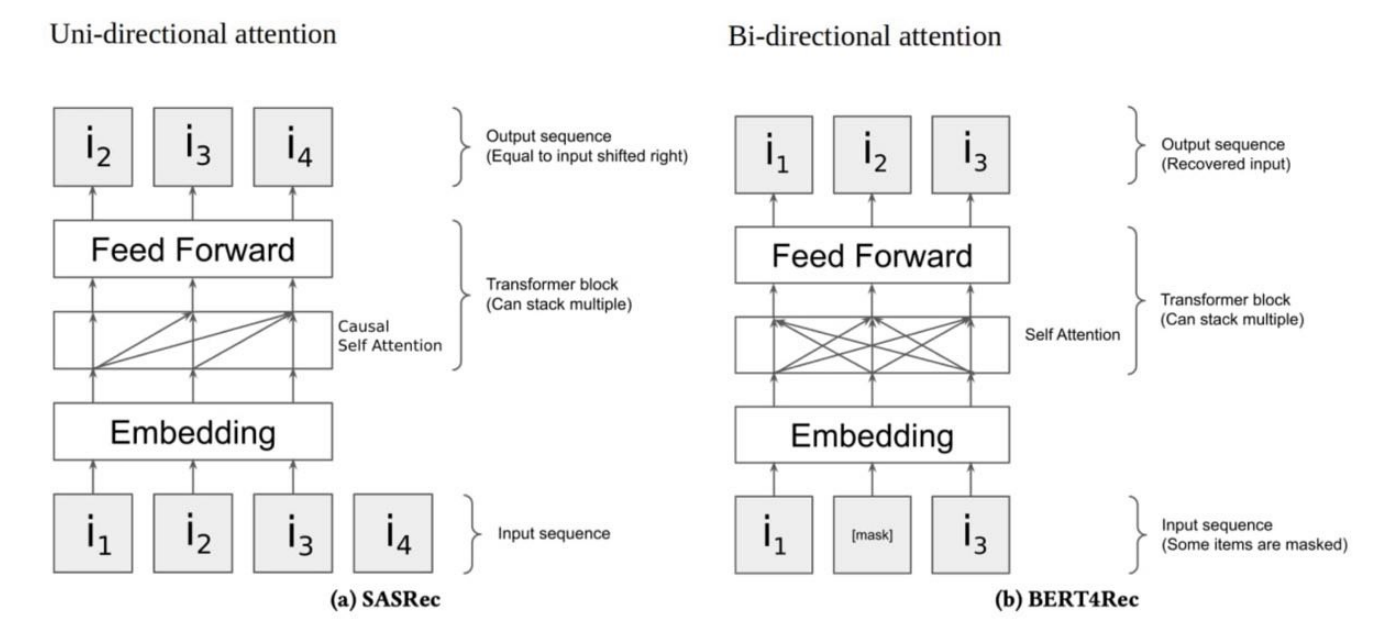

## RecTools implementation

We use dot product tying of user sequence embeddings (obtained after transformer blocks) and candidate item embeddings. Item embeddings are formed as sum of learnt item id embeddings and learnt item categorical features embeddings.

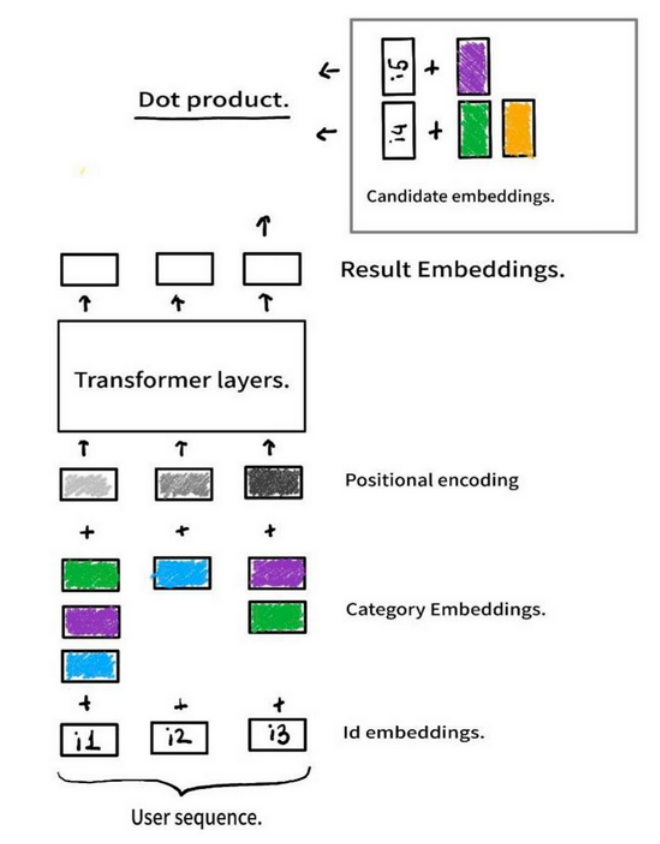

The following losses are supported:

| Losses                       | SASRec   |BERT4Rec         |
| ------------                 | ---------| --------------- |
| Softmax loss                 | ``+``        | ``+``               |
| BCE loss                     | ``+``        | ``+``               |
| gBCE loss                    | ``+``        | ``+``               |
| Variable number of negatives | ``+``        | ``+``               |


We also allow explicit customization of any part of the model:

| Customization options   | SASRec   |BERT4Rec         |
| ------------            | ---------| --------------- |
| Data preprocessing      | ``+``        | ``+``               |
| Item net for embeddings | ``+``        | ``+``               |
| Positional encoding     | ``+``        | ``+``               |
| Transformer layers      | ``+``        | ``+``               |
| Model training          | ``+``        | ``+``               |


\* customization options describe what parts of transformer model architecture can be changed by the user flexibly. For that user should inherit from the respective base class and pass a new class as a model parameter.

### Reference implementations 

1. BERT4Rec reference implementation: https://github.com/jaywonchung/BERT4Rec-VAE-Pytorch.git What's changed: we implemented dot product tying between session latent representation and item embeddings instead of linear layer at the end of the model. Also we use pytorch implementation of Multi-Head Attention.
2. SASrec reference implementation: https://github.com/asash/gSASRec-pytorch.git What's changed: we use pytorch implementation of Multi-Head Attention.

In addition to original model losses we implemented different loss options to both models including softmax, BCE and gBCE with variable number of negatives. Reference implementation for gBCE loss can be found here: https://github.com/asash/gsasrec

### Additional details
1. Xavier normal initialization for model parameters
2. Adam optimizer with betas=(0.9, 0.98)
3. We use `LightningModule` and `Trainer` from PyTorch Lightning to wrap model training and inference. Multi-GPU training is enabled out of the box.

## Application of Models

### Basic usage


* Specify maximum length of user-item interaction history with `session_max_len`
* Specify `loss` from "softmax", "BCE", "gBCE"
* Specify latent embeddings size with `n_factors`
* Specify number of transformer blocks with `n_blocks` 
* Specify number of attention heads with `n_heads`
* Specify `dropout_rate`
* Specify `lr` for learning rate 
* Specify `batch_size`
* Specify `epochs` for specific number of model training epochs
* Specify `deterministic=True` for deterministic model training
* Specify `verbose`

Parameter specific for BERT4Rec:

* Specify probability of a sequence item to be masked `mask_prob` 

In [13]:
sasrec = SASRecModel(
    session_max_len=20,
    loss="softmax",
    n_factors=64,
    n_blocks=1,
    n_heads=4,
    dropout_rate=0.2,
    lr=0.001,
    batch_size=128,
    epochs=1,
    verbose=1,
    deterministic=True,
)

# Here we just keep deafult params
bert4rec = BERT4RecModel(
    mask_prob=0.15,  # specify probability of masking tokens
    deterministic=True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [14]:
%%time
sasrec.fit(dataset);

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type                     | Params | Mode 
-----------------------------------------------------------------
0 | torch_model | TransformerTorchBackbone | 638 K  | train
-----------------------------------------------------------------
638 K     Trainable params
0         Non-trainable params
638 K     Total params
2.553     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


CPU times: user 16.3 s, sys: 1.12 s, total: 17.4 s
Wall time: 9min 54s


In [11]:
%%time
recos = sasrec.recommend(
    users=[test_user], 
    dataset=dataset,
    k=3,
    filter_viewed=True,
    on_unsupported_targets="warn"
)
recos.merge(items[["item_id", "title_orig"]], on="item_id").sort_values(["user_id", "rank"])

CPU times: user 119 ms, sys: 82.6 ms, total: 201 ms
Wall time: 201 ms


,user_id,item_id,score,rank,title_orig
0,176549,11749,3.427022,1,Incredibles 2
1,176549,12965,3.227504,2,Cars 3
2,176549,7571,3.096683,3,100% Wolf


### Adding item features. Selecting item net components

To add item features to the process of learning item embeddings it is necessary to pass those features to RecTools dataset during construction (like we did above in this tutorial). Also it is necessary to pass `CatFeaturesItemNet` to `item_net_block_types` during model initialization. Any combination of `IdEmbeddingsItemNet` and `CatFeaturesItemNet` is applicable.

By default our models use all features that are present in training dataset. Default model will use item features when they are present in dataset.

<b>Categorical features:</b>

For each pair of feature and feature value categorical feature embedding is created. Categorical feature embeddings are summed up with other embeddings for each item if they are present in the model.

<b>Numerical features:</b> <b>Are not supported.</b>

In [12]:
sasrec_ids_only = SASRecModel(
    deterministic=True,
    loss="softmax",
    item_net_block_types=(IdEmbeddingsItemNet,)  # Use only item ids
)
sasrec_ids_and_categories = SASRecModel(
    deterministic=True,
    loss="softmax",
    item_net_block_types=(IdEmbeddingsItemNet, CatFeaturesItemNet)  # Use item ids and cat features
)
sasrec_categories_only = SASRecModel(
    deterministic=True,
    loss="softmax",
    item_net_block_types=(CatFeaturesItemNet,)  # Use only cat item features
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


### Selecting losses 

RecTools supports 3 losses:

1. Softmax: requires no additional parameters. Calculated on full item catalog. Used by default.
2. BCE: user can specify number of negatives to be sampled with `n_negatives` parameter.
3. gBCE: user can specify number of negatives to be sampled with `n_negatives` parameter and calibration hyperparameter `gbce_t`

See "Losses" section in "Detailed SASRec and BERT4Rec description" below for full losses description and math.

In [13]:
sasrec_softmax = SASRecModel(
    deterministic=True,
    loss="softmax",
)

sasrec_bce = SASRecModel(
    deterministic=True,
    loss="BCE",
    n_negatives=50,
)
sasrec_gbce = SASRecModel(
    deterministic=True,
    loss="gBCE",
    n_negatives=50,
    gbce_t=0.2,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


### Customizing model 

* Specify minimum number of user interactions in dataset that is required to include user to model training with `train_min_user_interactions`
* Specify whether positional encoding should be used with `use_pos_emb`
* Specify whether key_padding_mask in multi-head attention should be used with `use_key_padding_mask`. BERT4Rec has it set to ``True`` by default. `SASRec` has it set to ``False`` by default because of explicit zero multiplication of padding embeddings inside transfomer layers that we inherited from the original implementation.

For custom classes: inherit from base class and pass custom class as model parameter

* Specify `item_net_block_types` for Item Net blocks from `(IdEmbeddingsItemNet, CatFeaturesItemNet)`, `(IdEmbeddingsItemNet,)`,            `(, CatFeaturesItemNet)` or custom embedding network. Inherit from `ItemNetBase`
* Specify `pos_encoding_type` for custom positional encoding logic. Inherit from `PositionalEncodingBase`
* Specify `transformer_layers_type` for custom transformer layers logic. Inherit from `TransformerLayersBase`
* Specify `data_preparator_type` for custom data processing logic. Inherit from `SessionEncoderDataPreparatorBase`
* Specify `lightning_module_type` for custom training logic. Inherit from `SessionEncoderLightningModuleBase`

### Cross-validation

In [14]:
# Use last week to validate model. Number of folds is set to 1 to speed up training
splitter = TimeRangeSplitter(
    test_size="7D",
    n_splits=1,
    filter_already_seen=True,
)

In [15]:
models = {
    "popular": PopularModel(),
    "ease": EASEModel(),
    "bert4rec_softmax_ids_and_cat": bert4rec,
    "sasrec_softmax_ids_and_cat": sasrec_softmax,
    "sasrec_bce_ids_and_cat": sasrec_bce,
    "sasrec_gbce_ids_and_cat": sasrec_gbce,
    "sasrec_softmax_ids_only": sasrec_ids_only,
    "sasrec_softmax_cat_only": sasrec_categories_only,
    "sasrec_bce_ids_only": SASRecModel(deterministic=True, loss="BCE", n_negatives=50, item_net_block_types=(IdEmbeddingsItemNet, )),
    "sasrec_bce_cat_only": SASRecModel(deterministic=True, loss="BCE", n_negatives=50, item_net_block_types=(CatFeaturesItemNet, )),
    "sasrec_gbce_ids_only": SASRecModel(deterministic=True, loss="gBCE", n_negatives=50, item_net_block_types=(IdEmbeddingsItemNet, )),
    "sasrec_gbce_cat_only": SASRecModel(deterministic=True, loss="gBCE", n_negatives=50, item_net_block_types=(CatFeaturesItemNet, )),
}

metrics = {
    "HitRate@10": HitRate(k=10),
    "MAP@10": MAP(k=10),
    "Serendipity@10": Serendipity(k=10),
    "CoveredUsers@10": CoveredUsers(k=10),  # how many test users received recommendations
    "AvgRecPopularity@10": AvgRecPopularity(k=10),  # average popularity of recommended items
    "Intersection@10": Intersection(k=10),  # intersection with recommendations from reference model
}

K_RECS = 10


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [16]:
%%time

# For each fold generate train and test part of dataset
# Then fit every model, generate recommendations and calculate metrics

cv_results = cross_validate(
    dataset=dataset,
    splitter=splitter,
    models=models,
    metrics=metrics,
    k=K_RECS,
    filter_viewed=True,
    ref_models=["popular"],  # pass reference model to calculate recommendations intersection
    validate_ref_models=True,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_epochs=3` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_epochs=3` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_epochs=3` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_epochs=3` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_epochs=3` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_epochs=3` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_epochs=3` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_epochs=3` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_epochs=3` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_epochs=3` reached.


CPU times: user 15h 2min 16s, sys: 7min 50s, total: 15h 10min 7s
Wall time: 2h 37min 44s


In [17]:
pivot_results = (
    pd.DataFrame(cv_results["metrics"])
    .drop(columns="i_split")
    .groupby(["model"], sort=False)
    .agg(["mean"])
)
pivot_results.columns = pivot_results.columns.droplevel(1)
pivot_results.to_csv("rectools_transformers_cv.csv", index=True)
pivot_results

,HitRate@10,MAP@10,AvgRecPopularity@10,Serendipity@10,Intersection@10_popular,CoveredUsers@10
model,,,,,,
popular,0.274365,0.080114,82236.761783,0.000002,1.000000,1.0
ease,0.191522,0.037317,15987.674248,0.000261,0.136901,1.0
bert4rec_softmax_ids_and_cat,0.341591,0.097810,49256.224578,0.000176,0.391448,1.0
sasrec_softmax_ids_and_cat,0.367610,0.107672,53651.582417,0.000279,0.424526,1.0
sasrec_bce_ids_and_cat,0.358316,0.100007,48322.991465,0.000323,0.376132,1.0
sasrec_gbce_ids_and_cat,0.358089,0.098112,48277.492343,0.000307,0.374561,1.0
sasrec_softmax_ids_only,0.317717,0.094235,69309.781054,0.000033,0.619626,1.0
sasrec_softmax_cat_only,0.302582,0.086132,36868.127081,0.000276,0.251032,1.0
sasrec_bce_ids_only,0.310558,0.088595,74938.036791,0.000017,0.679780,1.0


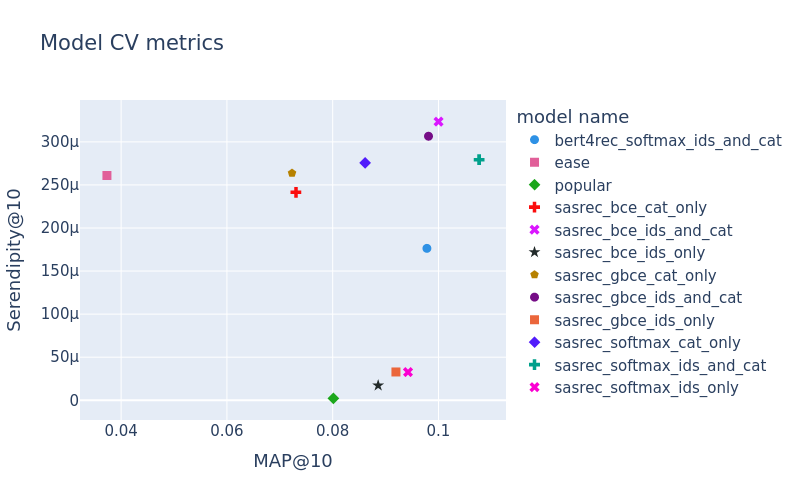

In [26]:
models_metrics = pivot_results.reset_index()[["model", "MAP@10", "Serendipity@10"]]

models_to_skip_meta = ["popular", "ease", "bert4rec_softmax_ids_and_cat"]
models_metadata = [
    {
        "model": model_name, 
        "item_net_block_types": ",".join(
            block for block in ["Id", "Cat"] 
            if re.search(block, str(model.get_params()["item_net_block_types"]))
        ),
    } 
    for model_name, model in models.items() if model_name not in models_to_skip_meta
]

app = MetricsApp.construct(
    models_metrics=models_metrics,
    models_metadata=pd.DataFrame(models_metadata),
    scatter_kwargs={
        "color_discrete_sequence": px.colors.qualitative.Dark24,
        "symbol_sequence": ['circle', 'square', 'diamond', 'cross', 'x', 'star', 'pentagon'],
    }
)
fig = app.fig
fig.update_layout(title="Model CV metrics", font={"size": 15})
fig.update_traces(marker={'size': 9})
fig.show("png")

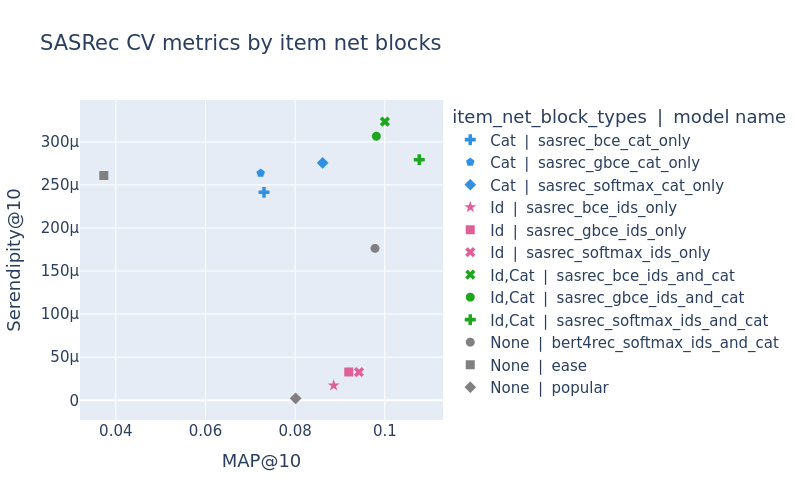

In [28]:
# For this plot metadata colouring was enabled
fig = app.fig
fig.update_layout(title="SASRec CV metrics by item net blocks",
                  font={"size": 15})
fig.update_traces(marker={'size': 9})
fig.show("png")

### Item-to-item recommendations

i2i recommendations are generated in the following way:

1. Get item embeddings received after the train stage
2. Calculate cosine similarity of catalog item embedding with target item embedding
3. Return k most similar items

In [18]:
# Prepare test item
test_item = 13865
items.loc[items['item_id'] == test_item, "title"]

6501    Devyataev
Name: title, dtype: object

In [19]:
%%time
recos = sasrec.recommend_to_items(
    target_items=[test_item], 
    dataset=dataset,
    k=3,
    filter_itself=True,
    items_to_recommend=None,
)
recos.merge(items[["item_id", "title_orig"]], on="item_id").sort_values(["item_id", "rank"])

CPU times: user 2.06 s, sys: 1.73 s, total: 3.79 s
Wall time: 3.81 s


,target_item_id,item_id,score,rank,title_orig
2,13865,3734,0.898868,3,Prababushka lyogkogo povedeniya
1,13865,9728,0.952629,2,Wrath of Man
0,13865,10440,0.961360,1,Khrustal'nyy


### Inference tricks (model known items and inference for cold users)

It may happen that SASRec or BERT4Rec filters out users with less than `train_min_user_interactions` interactions during the train stage. However, it is still possible to make recommendations for those users if they have at least one interaction in history with an item that was present at training.

As an example consider user 324373, for whom there is only one interaction in the dataset.

In [20]:
# Prepare test user with 1 interaction
test_user_one = 324373
print(interactions[interactions["user_id"] == test_user_one].shape)
interactions[interactions["user_id"] == test_user_one]

(1, 4)


,user_id,item_id,datetime,weight
2493287,324373,10440,2021-06-24,1


In [21]:
%%time
recos = sasrec.recommend(
    users=[test_user_one], 
    dataset=dataset,
    k=3,
    filter_viewed=True,
    on_unsupported_targets="warn"
)
recos.merge(items[["item_id", "title_orig"]], on="item_id").sort_values(["user_id", "rank"])

CPU times: user 133 ms, sys: 15.9 ms, total: 149 ms
Wall time: 149 ms


,user_id,item_id,score,rank,title_orig
0,324373,15297,4.755268,1,Klinika schast'ya
1,324373,9728,4.134816,2,Wrath of Man
2,324373,13865,4.025954,3,V2. Escape from Hell


Another case is when user that was filtered from train he doesn't have interactions with items that are known by the model. In this case user will not get recommendations.

In [22]:
# Prepare test user with items unknown by the model
test_user_no_recs = 14630
print(interactions[interactions["user_id"] == test_user_no_recs.shape])
interactions[interactions["user_id"] == test_user_no_recs.head(2)]

(1, 4)


,user_id,item_id,datetime,weight
2393877,14630,8871,2021-03-28,1


Flag `on_unsupported_target` allows to chose behaviour for processing users that cannot get recommendations from model.

Flag options:

* "ignore" - skip such users (show warning with the number of cold users)
* "warn" - skip such users but show a warning.
* "raise" - stop recommendation procedure with an error.

In [23]:
%%time
recos = sasrec.recommend(
    users=[test_user_no_recs], 
    dataset=dataset,
    k=3,
    filter_viewed=True,
    on_unsupported_targets="ignore"  # prevent raising an error
)
recos.merge(items[["item_id", "title_orig"]], on="item_id").sort_values(["user_id", "rank"])

CPU times: user 118 ms, sys: 2 ms, total: 120 ms
Wall time: 119 ms


,user_id,item_id,score,rank,title_orig


## Detailed SASRec and BERT4Rec description

### Dataset processing

Preprocessing steps will be shown using toy dataset:

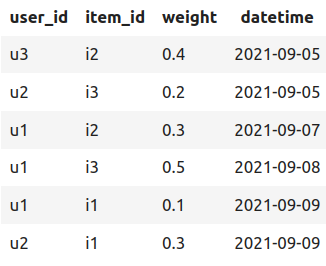

1. Filter out users with less than `train_min_user_interactions` interactions in the train dataset. 
    * <b>SASRec:</b> the model uses shifted user interactions to make next item prediction, thus, at least 2 items should be in the history (`train_min_user_interactions` > 1). 
    * <b>BERT4Rec:</b> the model bases on masked language modelling, thus, at least 2 item should be in the history but larger theshold could be more meaningful.
2. Leave `session_maxlen` most recent interactions for each user.

After the first 2 steps, some users and/or items may be filtered out from the train dataset. However, as it will be shown further, it is still possible to make recommendations for a previously unmet user, if at least one of his items is known.

3. Create user sessions: for each user specify items with which there was an interaction in the order from earliest to most recent. Sessions for example dataset are the following (u3 user was filtered out):
$$S^1 = (i2, i3, i1)$$
$$S^2 = (i3, i1)$$

4. Before the train stage each session is divided into train and target. 
    * <b>SASRec:</b> as the task is to predict the next item, the shifted sequence is considered as the target.
    $$S^1_{train} = (i2, i3), S^1_{target} = (i3, i1)$$
    $$S^2_{train} = (i3), S^2_{target} = (i1)$$
    * <b>BERT4Rec:</b> as the task is masked session modelling, following rules are applied:
    
    ```Text
    For each item in the user session generate probability p 
    If p < mask_prob: 
        p = p / mask_prob
        if p < 0.8:
            replace item with MASK
        if p > 0.8 and p < 0.9:
            replace item with another random item
    If p > mask_prob:
         Replace target for this item with PAD. We will not predict this element
    ```

    For our dataset an example of resulting train and target will be:
    $$S^1_{train} = (i2, MASK, i1), S^1_{target} = (i2, i3, PAD)$$
    $$S^2_{train} = (i2, i1), S^2_{target} = (i3, i1)$$

    Session that was formed for BERT4Rec is one element longer than the session for SASRec. This happens because of the way of processing "shifted sequence" target for SASRec.

5. Both train and target sequences are adjusted to take into account user-defined `session_maxlen`:
    * <b>SASRec:</b>
        * If session is longer than `session_maxlen`, cut earliest items
        * If session is shorter than `session_maxlen`, pad earliest items with PAD element
        $$S^1_{train} = (PAD, PAD, PAD, i2, i3), S^1_{target} = (PAD, PAD, PAD, i3, i1)$$
        $$S^2_{train} = (PAD, PAD, PAD, PAD, i3), S^2_{target} = (PAD, PAD, PAD, PAD, i1)$$
    * <b>BERT4Rec:</b>
        * If session is longer than `session_maxlen + 1`, cut earliest items
        * If session is shorter than `session_maxlen + 1`, pad earliest items with PAD element
$$S^1_{train} = (PAD, PAD, PAD, i2, MASK, i1), S^1_{target} = (PAD, PAD, PAD, i2, i3, PAD)$$
$$S^2_{train} = (PAD, PAD, PAD, PAD, i2, i1), S^2_{target} = (PAD, PAD, PAD, PAD, i3, i1)$$

During `recommend` stage SASRec model will take the last item latent representation for predicting next item. But BERT4Rec will put "MASK" token after the last item and will make predictions based on this added token latent representation. This explains why we need to make `+1` to `session_maxlen` for BERT4Rec during training. <b>The actual amount of interactions used for training and inference of both models is exactly the same. Each model will make predictions based on the most recent `session_maxlen` items for each user.</b> 

### Transformer layers

#### SASRec

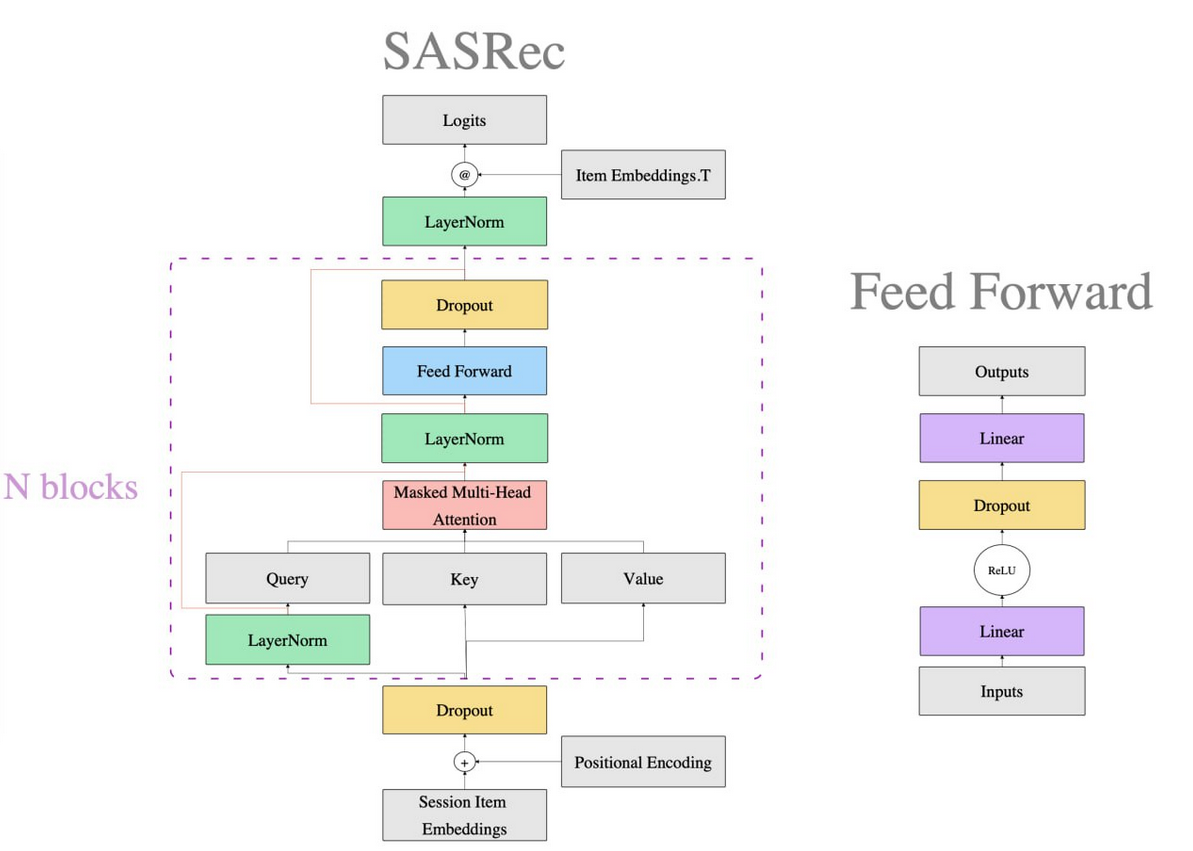

In contrast to BERT4Rec, SASRec is a causal model. It applies causal mask to enforce model focus solely on past interactions.

Uni-directional attention is implemented using a causal mask, which prevents model looking in the future.

#### BERT4Rec

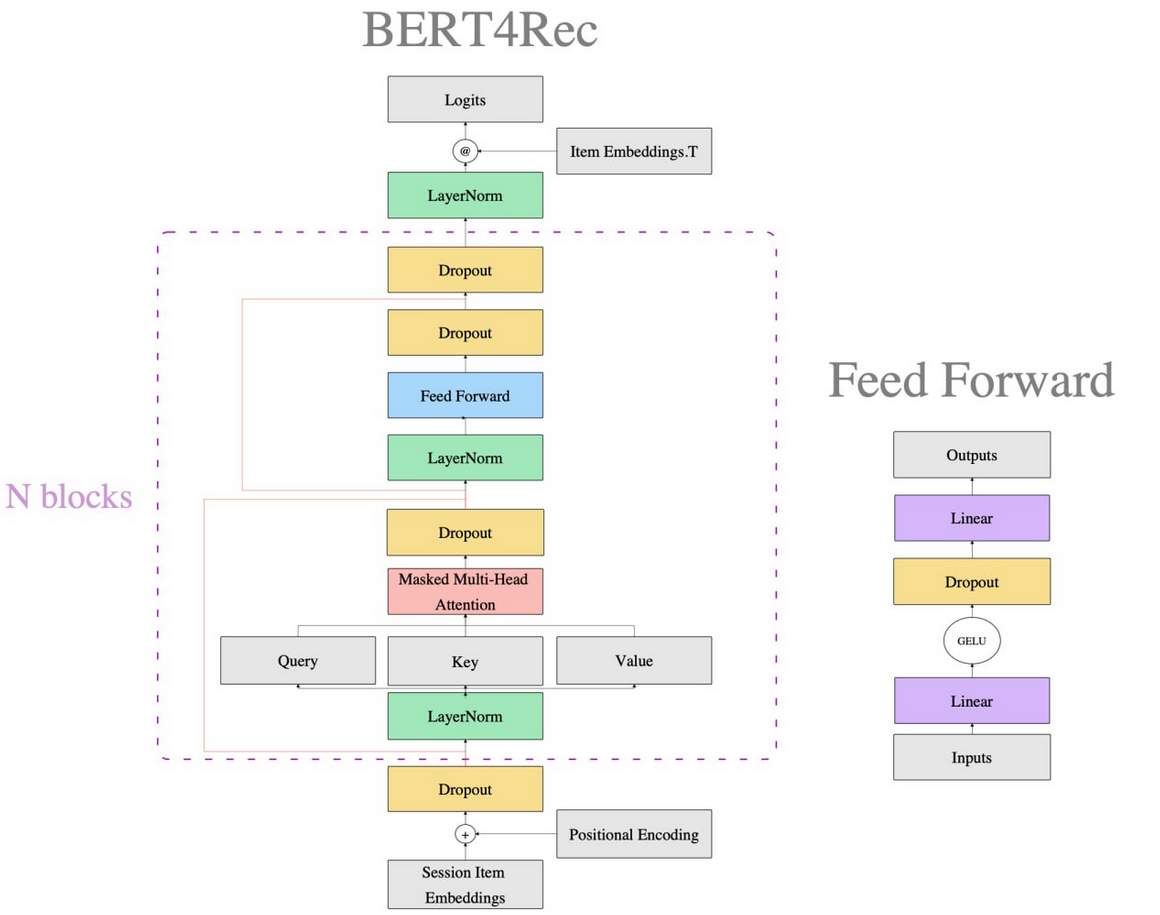

Bi-directional attention. In attention only padding mask is used, which masks padding elements not to allow them affect the results.

## Losses
#### Softmax loss
Softmax loss is a Cross Entropy loss calculated over the full catalog of items. As softmax loss finds probability distribution across all items, it returns the most precise results, however, for large catalogs such calculations are prohibitively inefficient. 

RecTools implementation uses `torch.nn.CrossEntropyLoss` with 'none' reduction
$$L = \{l_1, l_2, ..., l_N\}^T$$ 
$$l_n = -w_{y_n} log \frac{exp(x_{n,y_n})}{\sum_{c=1}^Cexp(x_{n,c})} \cdot I\{y_n \neq \text{ignore index}\}$$
After that 'sum' reduction is applied, excluding padding elements.

### Losses with negative sampling
Losses with negative sampling are needed to deal with the problem of computational inefficiency inherent to usage of full catalog. For that n negative items per positive are sampled and used for calculations.

RecTools implementation samples negatives uniformly from training dataset.

#### BCE loss
Binary Cross Entropy loss aims to improve computational efficiency by using a few sampled negatives instead of the full catalog for calculations. The problem is that in most cases performance degrades.

Logits $(x_n)$ - concat positive and negative logits.

Target $(y_n)$ - positive samples are marked as 1, negative as 0.

RecTools implementation uses `torch.nn.BCEWithLogitsLoss` with 'none' reduction
$$L = \{l_1, l_2, ..., l_N\}^T$$ 
$$l_n = -w_{y_n} [y_n log\sigma (x_n) + (1 - y_n) log(1 - \sigma (x_n))]$$
After that 'sum' reduction is applied, excluding padding elements.

#### gBCE loss
Models trained with negative sampling (BCE loss) tend to overestimate probabilities of positive interactions. To mitigate this effect gBCE loss can be used, which is actually BCE loss applied to transformed logits. It combines efficiency of BCE loss with better performance results.

Logit transformation is applied to positive logits only, negative logits remain unchanged:

$$ \text{transformed positive logits} = log(\frac{1}{\sigma^{-\beta}(s^+) - 1})$$
$$\beta = \alpha(t(1-\frac{1}{\alpha}) + \frac{1}{\alpha})$$
$$\alpha = \frac{1}{\text{number of unique items} - 1}$$
$$t - \text{calibration hyperparameter}$$

After that BCE loss is applied to concatenation of transformed positive logits and negative logits.

## Links
1. Transformers: [Attention Is All You Need](https://arxiv.org/abs/1706.03762)

### SASRec
1. SASRec original paper: [Self-Attentive Sequential Recommendation](https://arxiv.org/abs/1808.09781)
2. [Turning Dross Into Gold Loss: is BERT4Rec really better than SASRec?](https://arxiv.org/abs/2309.07602)
3. [gSASRec: Reducing Overconfidence in Sequential Recommendation Trained with Negative Sampling](https://arxiv.org/pdf/2308.07192)

### BERT4Rec
1. BERT4Rec original paper: [BERT4Rec: Sequential Recommendation with Bidirectional Encoder Representations from Transformer](https://arxiv.org/abs/1904.06690)
2. Comparison of BERT4Rec implementations: [A Systematic Review and Replicability Study of BERT4Rec for
Sequential Recommendation](https://arxiv.org/abs/2207.07483)